In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import numba


C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Question 1

## Geometry a)


First of all, we define some of the functions that we will use for this exercise.

In [24]:
# Set the size of the array
N = 500
J = 1


def create_array(N):
    '''Function to create a random array of N spins'''
    
    return(np.random.choice([-1,1],(N)))
 
    
#Calculate the whole energy of the array
def energy(array):
    '''Function to calculate the energy of the whole array,
    considering only closest neighbors'''
    
    #The function works by moving the array 1 place to the right
    # and multiplying the original array and the moved one.
    return -J*np.sum(array*np.roll(array,1))


def mag(array):
    '''Function to calculate the magnetization per site
    (the order parameter)'''
    
    return(np.abs(array.mean()))


def calc(array):
    '''Function that returns both the energy and magnetization'''
    
    return(energy(array),mag(array))


@numba.njit
def update(array,T,N):
    '''Function that tries to do N flips to the array following
    the metropolis algorithm. It picks a random site in the chain and
    calculates the difference in energy obtained by flipping it.
    Then, it definitely flips it if the energy decreases or 
    does it with probability  e^{-\Delta E/ kT} if the energy increases.'''
    
    for c in range(N):
        #Create the random position x
        x = np.random.randint(N)
        #Calculate the difference in energy of flipping x
        neigh_sum = array[x-1] + array[(x+1)%N]
        delta_E = 2*array[x]*neigh_sum
    
    #Metropolis acceptance procedure
        if np.random.random() < np.exp(-1/T*delta_E):
            #Flip the spin
            array[x] *= -1

            
def montecarlo(T,nmax,n0,N):
    '''Function that makes the whole montecarlo algorithm
    for a given temperature T, maximum number of iterations nmax
    and number of iterations from which to start averaging n0'''
    
    array=create_array(N)
    results = []
    
    if n0 == 0:
        results.append(calc(array))

    for i in range(nmax):
        update(array,T,N)
        if i >= n0:
            results.append(calc(array))    

    return(np.array(results))
    
    
def many_montecarlo(Ts, nmax,n0,N):
    ''' Function to run many montecarlo algorithms with temperatures Ts'''
    
    all_results = []
    for T in Ts:
        all_results.append(montecarlo(T,nmax,n0,N))
    return np.array(all_results)



We can take a look at the results for a given temperature first. Let's say for $T = 1$, $N=500$ and $1000$ iterations:

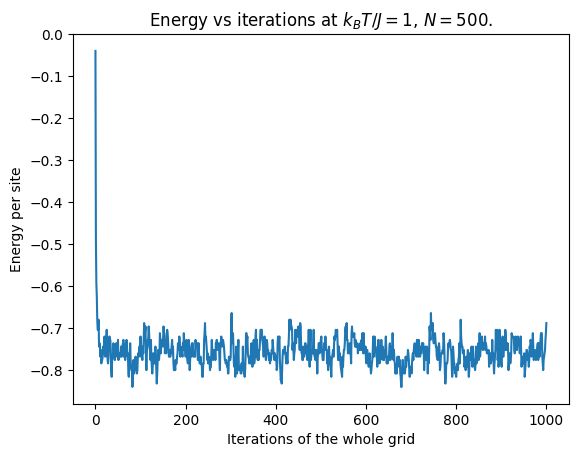

In [8]:
T = 1
N = 500


result = montecarlo(T,1000,0,N)
plt.plot(result[:,0]/500)
plt.title("Energy vs iterations at $k_BT/J=1$, $N=500$.")
plt.xlabel("Iterations of the whole grid")
plt.ylabel("Energy per site")

plt.show()

We can see that the energy converges pretty quickly to an almost stable value. Now we will do the same for many temperatures to find how many iterations are needed for a reasonable convergence.

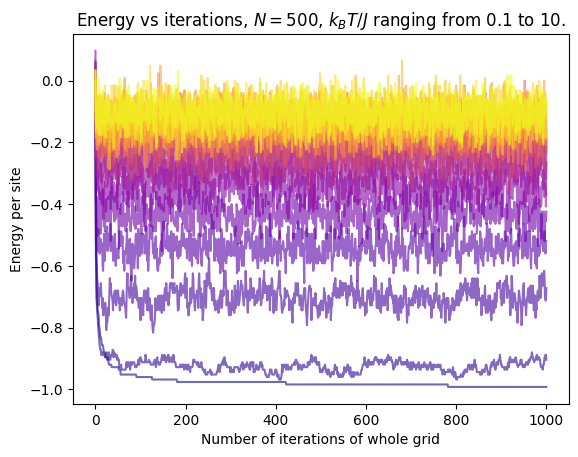

In [5]:
import matplotlib.pylab as pl

Ts =np.linspace(0.1,10,20)

colors = pl.cm.plasma(np.linspace(0,1,20))

N=500
for i,T in enumerate(Ts):
    res = montecarlo(T,1000,0,N)
    plt.plot(res[:,0]/N,alpha=0.6, color = colors[i],
            label = np.around(T,2))
    
plt.title("Energy vs iterations, $N=500$, $k_BT/J$ ranging from 0.1 to 10.")
plt.xlabel("Number of iterations of whole grid")
# plt.legend()
plt.ylabel("Energy per site")
plt.show()

The change in color shows different temperatures, going from purple to yellow. We can see that at around 100 iterations all temperatures have pretty much converged and are just fluctuating around. Therefore, running a warmup of around 500 iterations will definitely give more than enough time for the system to thermalize. 

Therefore, we will now take the average of the order parameter at many different temperatures, taking more than 500 iterations on each.

Text(0.5, 0, 'Temperature ($k_b T/J$)')

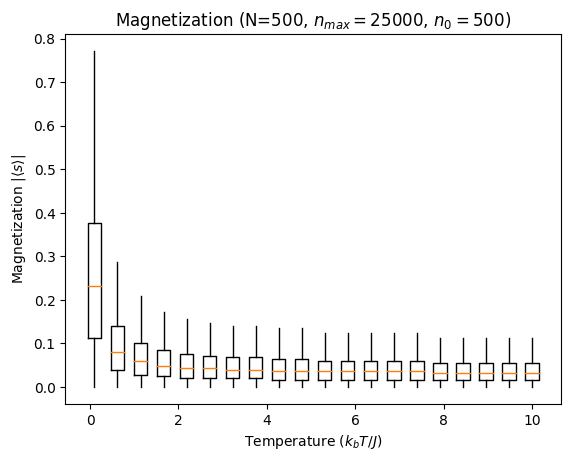

In [9]:
Ts =np.linspace(0.5,10,20)
N = 500
all_states = many_montecarlo(Ts,25000, 500,N)

plt.boxplot(all_states[:,:,1].T,positions= np.linspace(0.1,10,20),
            widths=0.3, showcaps =False,
           manage_ticks=False,
           showfliers =False);
plt.title("Magnetization (N=500, $n_{max} = 25000$, $n_0 = 500$)")
plt.ylabel(r"Magnetization $|\langle s \rangle|$")
plt.xticks([0,2,4,6,8,10])
plt.xlabel(r"Temperature ($k_b T/J$)")

### Geometry b): With added random connections

In [19]:
def create_connections(N):
    '''Function to create random connections on an array N units long.
    The function creates an array "con", such that con[i] is the list
    of spins connected to the ith spin.'''
    
    #Create the array con.
    con = np.zeros((N,4),int)
    #permute the range 1,..,N to create the new connections
    # making sure no element is mapped to itself or to the
    # connections we already want (the previous and next element)
    while True:
        perm = random.sample(range(N),N)
        
        for i in range(N):
            if perm[i] == i:
                break
            if perm[perm[i]] == i:
                break
            if perm[i] == (i-1)%N:
                break
            if perm[i] == (i+1)%N:
                break
        break
    
    #The ith spin will be connected to i-1,i+1, p[i] (and p[i] connected to 
    # the ith spin). Creating a total of N new connections between two spins, 
    # such that now on average, each spin has two new connections. 
    
    for i in range(N):
        con[i][0] = (i-1)%N
        con[i][1] = (i+1)%N
        con[i][2] = perm[i]
        con[perm[i]][3] = i
        
    return(con)
    
'''Now we change the previous functions so that they work with these new
connections. Actually, the only thing that needs to change is how we 
compute the neigh_sum.'''
    
#Calculate the whole energy of the array
def energy2(array,con,N):
    en = 0
    
    for x in range(N):
        con_x = con[x]
        neigh_sum = array[con_x[0]]+ array[con_x[1]]\
        +array[con_x[2]] + array[con_x[3]]

        en -= array[x]*neigh_sum/2
    return(en)

def calc2(array,con,N):
    return(energy2(array,con,N),mag(array)) 

@numba.njit
def update2(array,con,T,N):
    for _ in range(N):
        x = np.random.randint(N)
        con_x = con[x]
        
        neigh_sum = array[con_x[0]]+ array[con_x[1]]\
        +array[con_x[2]] + array[con_x[3]]
        
        delta_E = 2*array[x]*neigh_sum
    
    #Metropolis acceptance procedure
        if np.random.random() < np.exp(-1/T*delta_E):
            array[x] *= -1
            
            
def montecarlo2(T,nmax,n0,con,N):
    array = create_array(N)
    
    results = []
    if n0 == 0:
        results.append(calc2(array,con,N))
    
    for i in range(nmax):
        update2(array,con,T,N)
        if i >= n0:
            results.append(calc2(array,con,N))
    

    return(np.array(results))
    
def many_montecarlo2(Ts, nmax,n0,con,N):
    all_results = []
    for T in Ts:
        all_results.append(montecarlo2(T,nmax,n0,con,N))
    return np.array(all_results)




We can try it out for one temperature

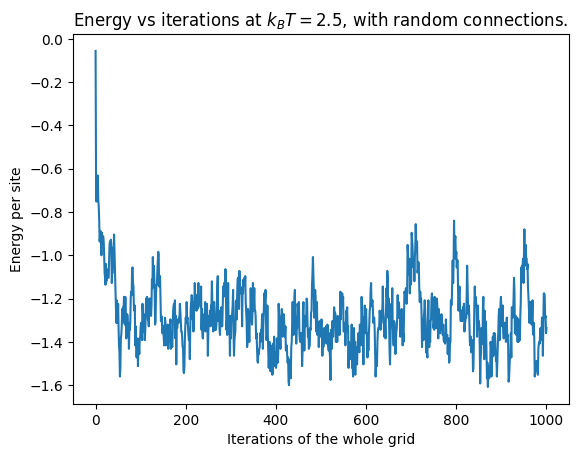

In [12]:
array=create_array(N)
con = create_connections(N)

T = 2.5
result = montecarlo2(T,1000,0,con,N)
plt.plot(result[:,0]/500)
plt.title("Energy vs iterations at $k_BT=2.5$, with random connections.")
plt.xlabel("Iterations of the whole grid")
plt.ylabel("Energy per site")

plt.show()

Now for many temperatures to see how they converge.

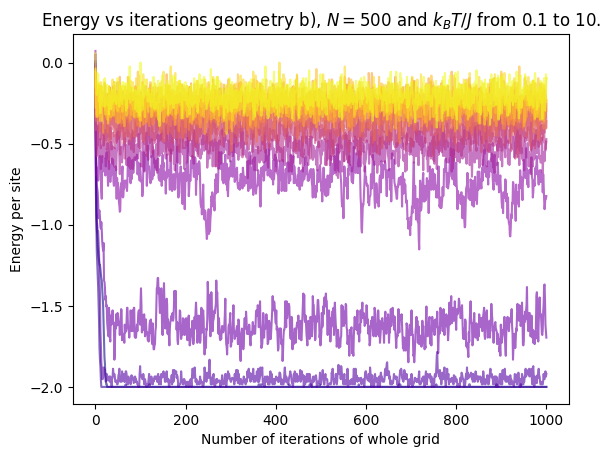

In [13]:
import matplotlib.pylab as pl

con = create_connections(N)

Ts =np.linspace(0.1,10,15)
N = 500
colors = pl.cm.plasma(np.linspace(0,1,15))


for i,T in enumerate(Ts):
    res = montecarlo2(T,1000,0,con,500)
    plt.plot(res[:,0]/N,alpha=0.6, color = colors[i])
    
plt.title("Energy vs iterations geometry b), $N=500$ and $k_B T / J$ from 0.1 to 10.")
plt.xlabel("Number of iterations of whole grid")
plt.ylabel("Energy per site")
plt.show()

100 iterations seem to be enough for thermalization. Now we can calculate the expected value of the magnetization for different temperatures. We will use 300 iterations for thermalization and then 5000 total iterations.

Text(0.5, 0, 'Temperature ($k_b T/J$)')

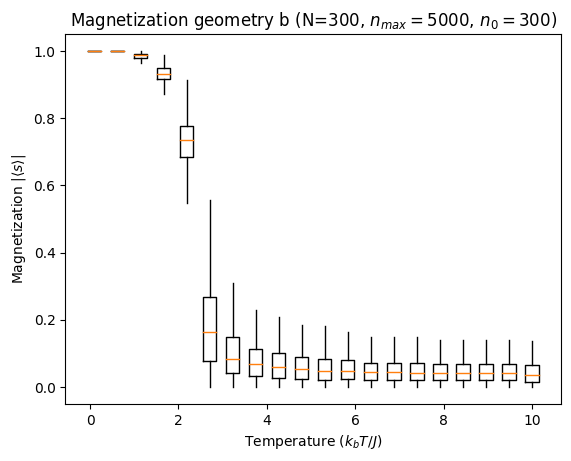

In [20]:
Ts =np.linspace(0.5,10,20)
N = 500

all_states = many_montecarlo2(Ts,5000, 300,con,N)

plt.boxplot(all_states[:,:,1].T,positions= np.linspace(0.1,10,20),
            widths=0.3, showcaps =False,
           manage_ticks=False,
           showfliers =False);
plt.title("Magnetization geometry b (N=300, $n_{max} = 5000$, $n_0 = 300$)")
plt.ylabel(r"Magnetization $|\langle s \rangle|$")
plt.xticks([0,2,4,6,8,10])
plt.xlabel(r"Temperature ($k_b T/J$)")


Since there seems to be something interesting happening at around $T=2$ or $3$, we will zoom into that part and do the same as before but with temperatures from $1$ to $4$.


Text(0.5, 0, 'Temperature ($k_b T/J$)')

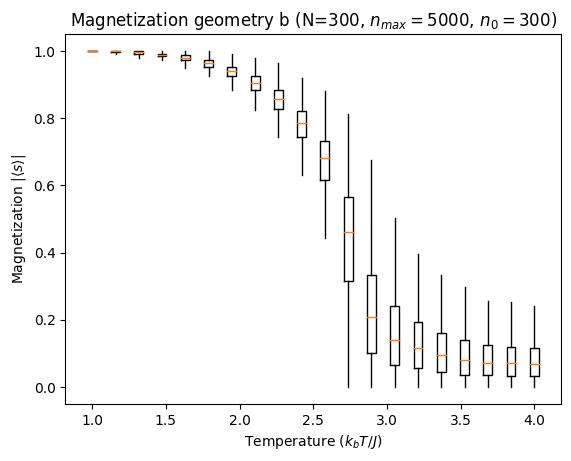

In [22]:
Ts =np.linspace(1,4,20)
N = 500

all_states = many_montecarlo2(Ts,5000, 300,con,N)


plt.boxplot(all_states[:,:,1].T,positions= np.linspace(1,4,20),
            widths=0.06, showcaps =False,
           manage_ticks=False,
           showfliers =False);
plt.title("Magnetization geometry b (N=300, $n_{max} = 5000$, $n_0 = 300$)")
plt.ylabel(r"Magnetization $|\langle s \rangle|$")
plt.xticks([1,1.5,2,2.5,3,3.5,4])
plt.xlabel(r"Temperature ($k_b T/J$)")


# 2. Explore the possible phase transition behaviour

We will repeat the last experiments but for many values of $N$, to see what happens in the thermodynamic limit $N \rightarrow \infty$

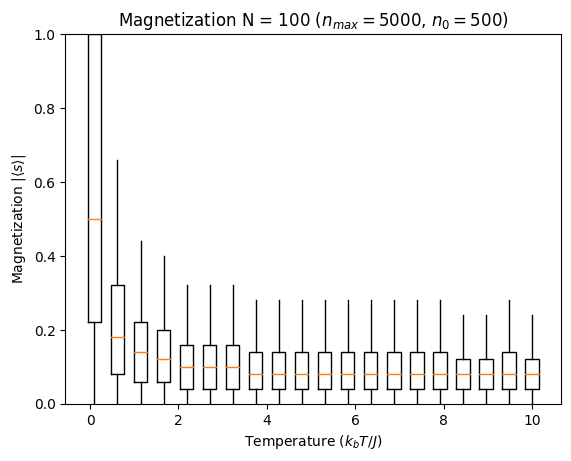

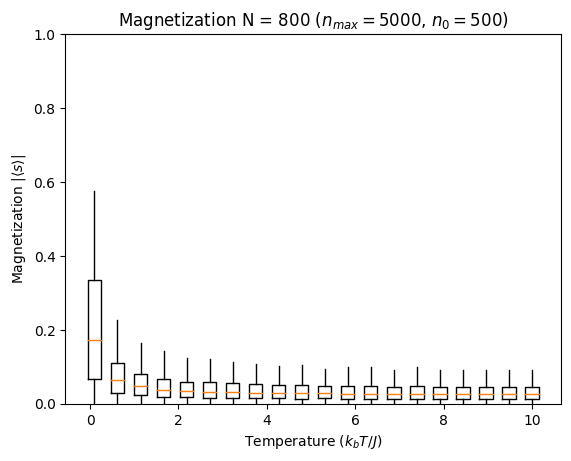

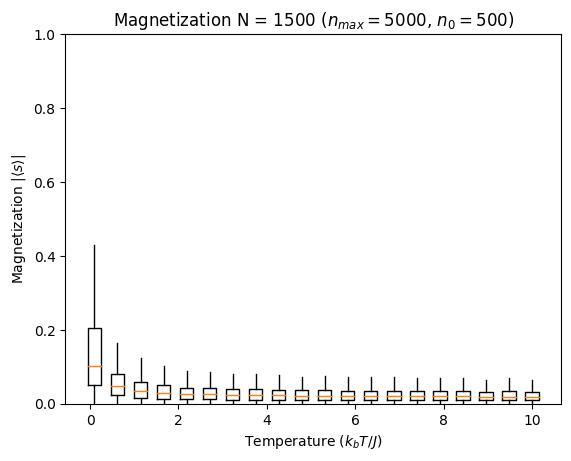

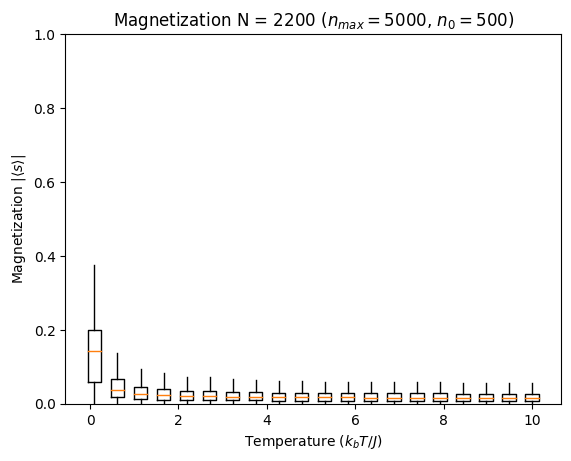

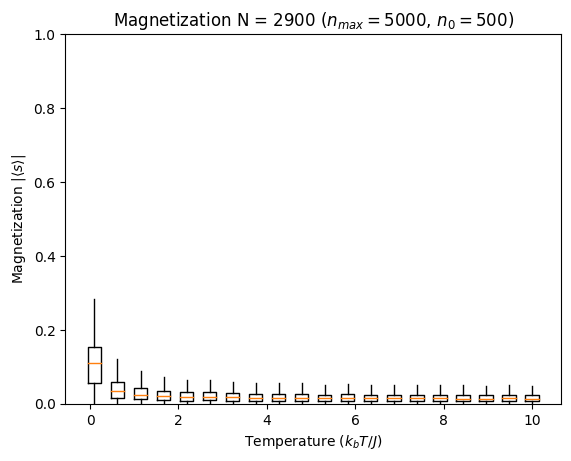

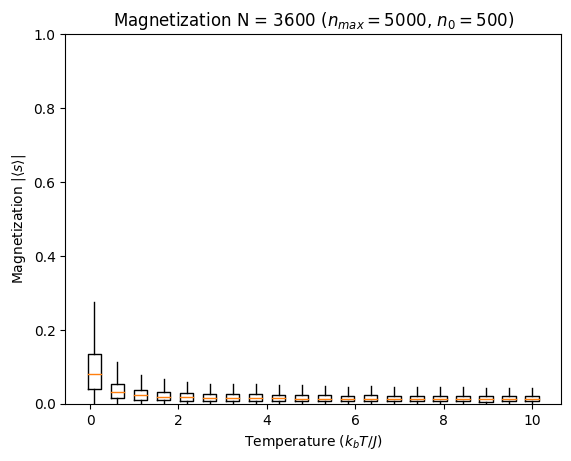

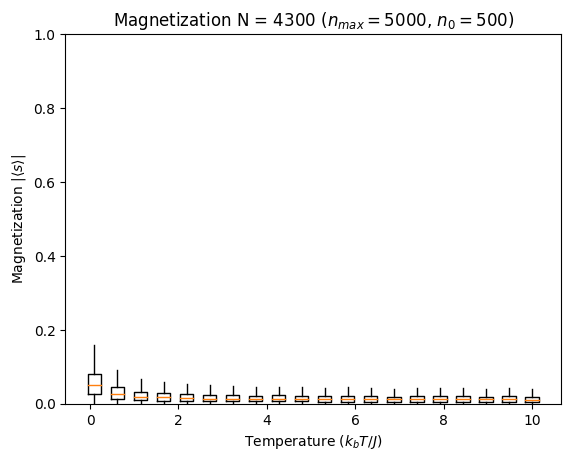

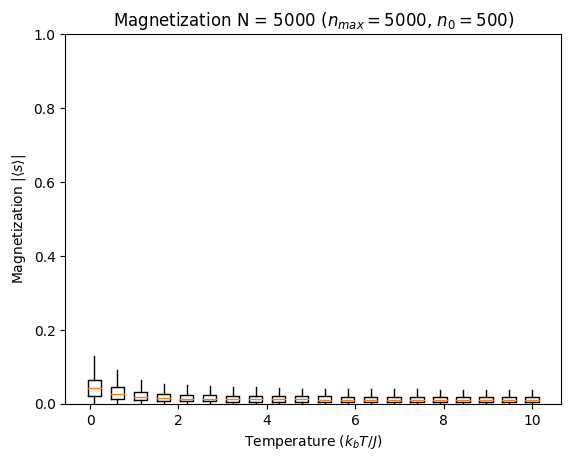

In [25]:
#We do it for values of $N$ between 100 and 5000:
for N in np.linspace(100,5000,8):
    N = int(N)
    Ts =np.linspace(0.5,10,20)

    all_states = many_montecarlo(Ts,5000, 500,N)
    
    plt.boxplot(all_states[:,:,1].T,positions= np.linspace(0.1,10,20),
            widths=0.3, showcaps =False,
           manage_ticks=False,
           showfliers =False);
    plt.title("Magnetization N = "+ str(N) + " ($n_{max} = 5000$, $n_0 = 500$)")
    plt.ylabel(r"Magnetization $|\langle s \rangle$|")
    plt.xticks([0,2,4,6,8,10])
    plt.xlabel(r"Temperature ($k_b T/J$)")
    
    plt.ylim([0,1])
    
    plt.show()

We can see that as $N$ gets bigger, the result is always to have 0 magnetization, no matter the value of the temperature.

#### Geometry B

2.763157894736842


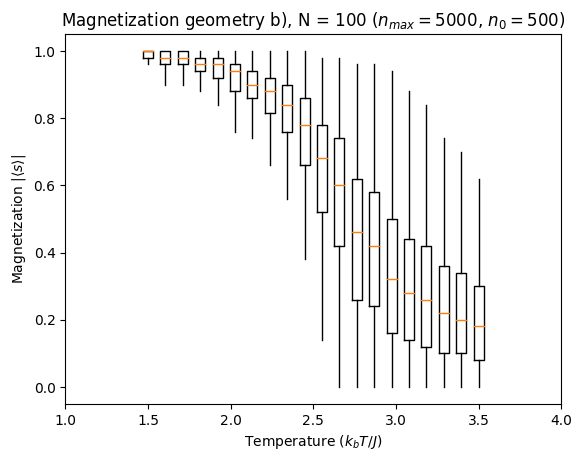

2.763157894736842


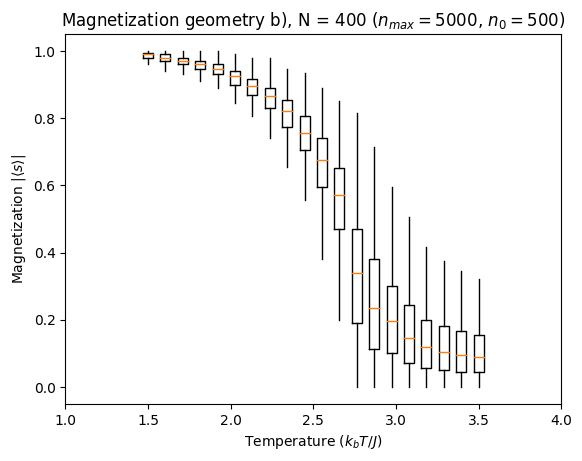

2.763157894736842


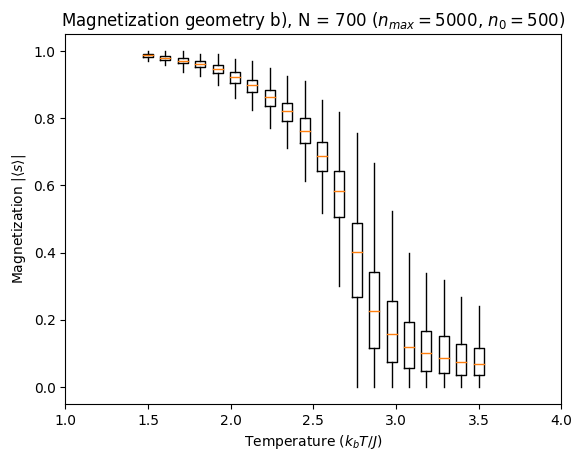

2.763157894736842


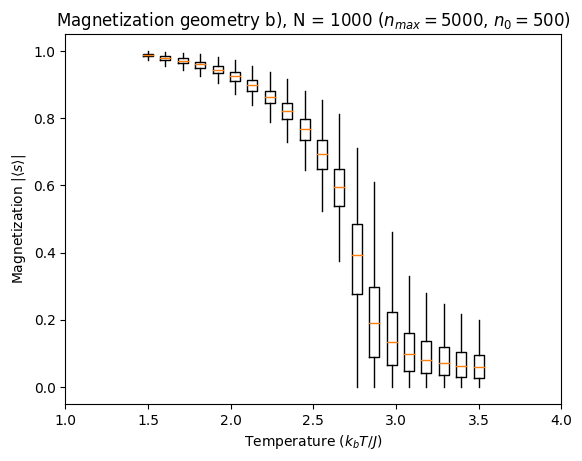

2.763157894736842


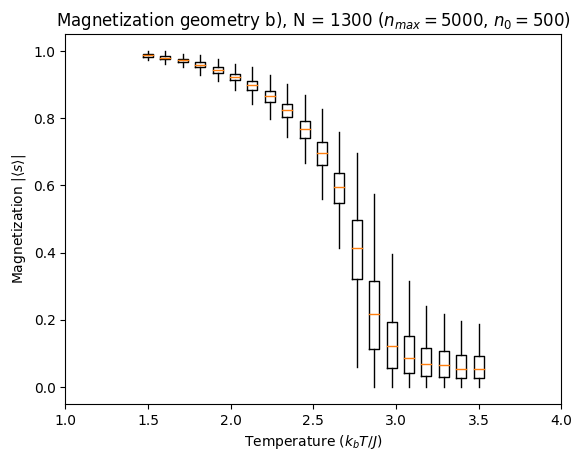

2.763157894736842


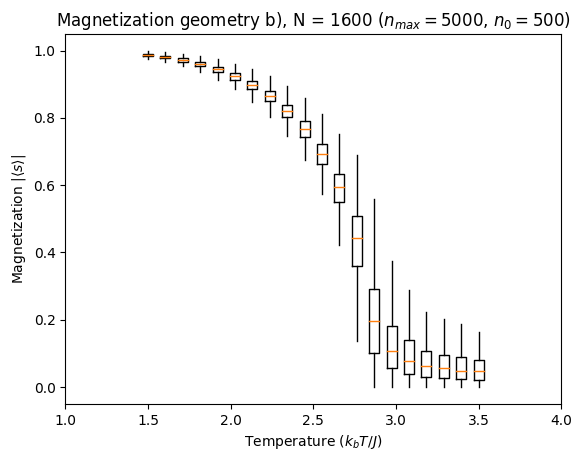

2.8684210526315788


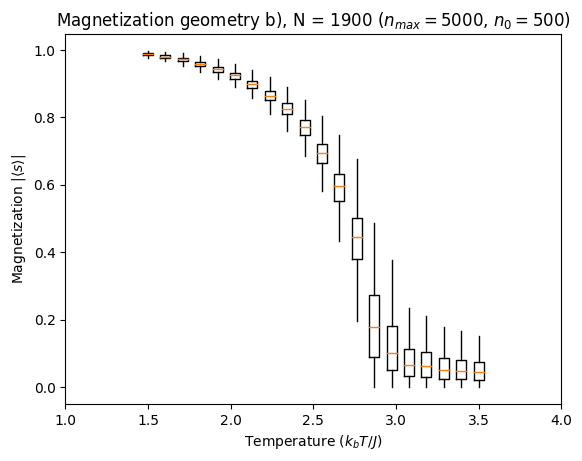

KeyboardInterrupt: 

In [42]:
#We do the same for geometry B.

Tcs = []
for N in np.linspace(100,2500,9):
    N = int(N)
    Ts =np.linspace(1.5,3.5,20)
    con = create_connections(N)

    all_states = many_montecarlo2(Ts,5000, 500,con,N)
    
    #Calculate the xi value
    xis = []
    for i in range(len(Ts)):
        xis.append(np.std(all_states[i][:,1])**2/T)

        
    print(Ts[np.argmax(xis)])
    Tcs.append(Ts[np.argmax(xis)])
    
    plt.boxplot(all_states[:,:,1].T,positions= np.linspace(1.5,3.5,20),
            widths=0.06, showcaps =False,
           manage_ticks=False,
           showfliers =False);
    plt.title("Magnetization geometry b), N = "+ str(N) + " ($n_{max} = 5000$, $n_0 = 500$)")
    plt.ylabel(r"Magnetization $|\langle s \rangle|$")
    plt.xticks([1,1.5,2,2.5,3,3.5,4])
    plt.xlabel(r"Temperature ($k_b T/J$)")
    
    
    plt.show()